In [3]:
pip install pyspark

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import os
import re
import sys
from pyspark.sql import SparkSession
import gzip

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

<h1>Loading and Viewing the NASA Log Dataset</h1>

In [5]:
spark = SparkSession.builder \
    .appName("MyApp") \
    .getOrCreate()

sc = spark.sparkContext

In [6]:
def combine_log_files(file1, file2, output_file):
    with open(output_file, 'wb') as outfile:
        for filename in [file1, file2]:
            with open(filename, 'rb') as infile:
                outfile.write(infile.read())

In [7]:
# File names with .txt extension
july_log = "access_log_Jul95.txt"
august_log = "access_log_Aug95.txt"
combined_log = "access_log_JulAug_95.txt"

# Combine the files
combine_log_files(july_log, august_log, combined_log)

print(f"Files {july_log} and {august_log} have been combined into {combined_log}")

Files access_log_Jul95.txt and access_log_Aug95.txt have been combined into access_log_JulAug_95.txt


In [8]:
import glob

raw_data_file = 'access_log_JulAug_95.txt'

print(raw_data_file)

access_log_JulAug_95.txt


<h3>Taking a look at the metadata of our dataframe</h3>

In [9]:
base_df = spark.read.text("access_log_JulAug_95.txt")
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [10]:
type(base_df)

pyspark.sql.dataframe.DataFrame

*Below is the conversion of the DataFrame to an RDD.*

In [11]:
base_df_rdd = base_df.rdd
type(base_df_rdd)

pyspark.rdd.RDD

<h3>Viewing sample data in our dataframe</h3>

In [12]:
base_df.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179|
|burger.letters.com - - 

*It can be seen as above, our data needs to be wrangled and parsed*

*Accessing data from an RDD is somewhat different. The following RDD illustrates how the data representation varies.*

In [13]:
base_df_sample = base_df.limit(10)
base_df_sample.collect()

[Row(value='199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245'),
 Row(value='unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0'),
 Row(value='205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985'),
 Row(value='d104.aa.net - - [01/Ju

<h1>Data Wrangling</h1>

<h3>Data Understanding</h3>

*The data shown above follows the <u>Common Log Format</u>.*

*The fields are: <b>remotehost&nbsp;&nbsp;&nbsp;&nbsp;rfc931&nbsp;&nbsp;&nbsp;&nbsp;authuser&nbsp;&nbsp;&nbsp;&nbsp;[date]&nbsp;&nbsp;&nbsp;&nbsp;"request"&nbsp;&nbsp;&nbsp;&nbsp;status&nbsp;&nbsp;&nbsp;&nbsp;bytes</b>*


| Field      | Meaning                                                                                  |
|------------|------------------------------------------------------------------------------------------|
| remotehost | Remote hostname (or IP number if DNS hostname is not available or if DNSLookup is off). |
| rfc931     | The remote logname of the user if at all it is present.                                 |
| authuser   | The username of the remote user after authentication by the HTTP server.                |
| [date]     | Date and time of the request.                                                           |
| "request"  | The request, exactly as it came from the browser or client.                             |
| status     | The HTTP status code the server sent back to the client.                                |
| bytes      | The number of bytes (Content-Length) transferred to the client.                         |


In [14]:
print((base_df.count(), len(base_df.columns)))

(3461612, 1)


In [15]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245',
 'unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085',
 'burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0',
 '199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0',
 '205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985',
 'd104.aa.net - - [01/Jul/1995:00:00:13 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '129.94.144.152 - - [01/Jul/

### Extracting host names

In [16]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts

['199.72.81.55',
 'unicomp6.unicomp.net',
 '199.120.110.21',
 'burger.letters.com',
 '199.120.110.21',
 'burger.letters.com',
 'burger.letters.com',
 '205.212.115.106',
 'd104.aa.net',
 '129.94.144.152',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'd104.aa.net',
 'd104.aa.net']

### Extracting timestamps

In [17]:
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:15 -0400',
 '01/Jul/1995:00:00:15 -0400']

### Extracting HTTP Request Method, URIs and Protocol

In [18]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol

[('GET', '/history/apollo/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/mission-sts-73.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/liftoff.html', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/sts-73-patch-small.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/video/livevideo.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/countdown.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/KSC-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0')]

### Extracting HTTP Status Code


In [19]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['200', '200', '200', '304', '200', '304', '200', '200', '200', '200', '200', '200', '200', '200', '200']


### Extracting HTTP Response Content Size

In [20]:
content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['6245', '3985', '4085', '0', '4179', '0', '0', '3985', '3985', '7074', '40310', '786', '1204', '40310', '786']


### Combine

In [21]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    

### Findings missing values

In [22]:
(base_df.filter(base_df['value'].isNull()).count())

0

In [23]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()| 
                             logs_df['timestamp'].isNull() | 
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

33904

As you can see the result, in this dataset we have over 33K missing values

### Finding null counts

In [24]:
logs_df.columns

['host',
 'timestamp',
 'method',
 'endpoint',
 'protocol',
 'status',
 'content_size']

In [25]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum
def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)
# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       33904|
+----+---------+------+--------+--------+------+------------+



### Handling nulls in HTTP status

In [26]:
null_status_df = base_df.filter(~base_df['value'].rlike(r'\s(\d{3})\s'))
null_status_df.count()

0

In [27]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       33904|
+----+---------+------+--------+--------+------+------------+



### Handling nulls in HTTP content size

In [28]:
null_content_size_df = base_df.filter(~base_df['value'].rlike(r'\s\d+$'))
null_content_size_df.count()

33904

In [29]:
null_content_size_df.take(10)

[Row(value='dd15-062.compuserve.com - - [01/Jul/1995:00:01:12 -0400] "GET /news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt HTTP/1.0" 404 -'),
 Row(value='dynip42.efn.org - - [01/Jul/1995:00:02:14 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:02:40 -0400] "GET /software/winvn HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:03:24 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='link097.txdirect.net - - [01/Jul/1995:00:05:06 -0400] "GET /shuttle HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:13 -0400] "GET /shuttle/missions/sts-78/news HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:58 -0400] "GET /shuttle/missions/sts-72/news HTTP/1.0" 302 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:19 -0400] "GET /pub/winvn/readme.txt HTTP/1.0" 404 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:28 -0400] "GET

In [30]:
#fix rows with null content_size
logs_df = logs_df.na.fill({'content_size':0})

In [31]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



### Handling temporal fields (Timestamp)

In [32]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20]))

In [33]:
sample_ts = [item['timestamp'] for item in logs_df.select('timestamp').take(5)]
sample_ts

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400']

In [34]:
[parse_clf_time(item) for item in sample_ts]

['1995-07-01 00:00:01',
 '1995-07-01 00:00:06',
 '1995-07-01 00:00:09',
 '1995-07-01 00:00:11',
 '1995-07-01 00:00:11']

In [35]:
logs_df.dtypes

[('host', 'string'),
 ('timestamp', 'string'),
 ('method', 'string'),
 ('endpoint', 'string'),
 ('protocol', 'string'),
 ('status', 'int'),
 ('content_size', 'int')]

In [36]:
udf_parse_time = udf(parse_clf_time)

logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
logs_df.show(10, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|1995-07-01 00:00:11|
|  burger.letters.com|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|1995-07-01 00:00:12|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   200|           0|1995-07-01 00:00:12|


In [37]:
logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [38]:
logs_df.limit(5).toPandas()

,host,method,endpoint,protocol,status,content_size,time
0,199.72.81.55,GET,/history/apollo/,HTTP/1.0,200,6245,1995-07-01 00:00:01
1,unicomp6.unicomp.net,GET,/shuttle/countdown/,HTTP/1.0,200,3985,1995-07-01 00:00:06
2,199.120.110.21,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085,1995-07-01 00:00:09
3,burger.letters.com,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0,1995-07-01 00:00:11
4,199.120.110.21,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179,1995-07-01 00:00:11


In [39]:
logs_df.cache()

DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

## DATA ANALYSIS 

### Content size statistics

In [40]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,3461612
1,mean,18928.844398216785
2,stddev,73031.47260949262
3,min,0
4,max,6823936


In [41]:
from pyspark.sql import functions as F

(logs_df.agg(F.min(logs_df['content_size']).alias('min_content_size'),
             F.max(logs_df['content_size']).alias('max_content_size'),
             F.mean(logs_df['content_size']).alias('mean_content_size'),
             F.stddev(logs_df['content_size']).alias('std_content_size'),
             F.count(logs_df['content_size']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,0,6823936,18928.844398,73031.472609,3461612


### HTTP Status Code Analysis

In [42]:
status_freq_df = (logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())

print('Total distinct HTTP status codes: ',status_freq_df.count())

Total distinct HTTP status codes:  8


In [43]:
content_freq_df = (logs_df
                     .groupBy('content_size')
                     .count()
                     .sort('content_size')
                     .cache())

print('Total content_size: ',content_freq_df.count())
# Display unique method names
unique_methods = content_freq_df.select("content_size").rdd.flatMap(lambda x: x).collect()
print("Unique content:", unique_methods)

Total content_size:  16502
Unique content: [0, 28, 50, 60, 62, 65, 66, 68, 72, 74, 75, 76, 77, 79, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 116, 128, 130, 136, 148, 156, 166, 168, 172, 176, 178, 180, 205, 206, 207, 210, 211, 220, 225, 226, 227, 228, 229, 230, 231, 234, 235, 236, 239, 241, 245, 262, 263, 283, 285, 286, 291, 300, 302, 305, 306, 308, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 339, 341, 342, 343, 344, 345, 348, 350, 351, 352, 355, 360, 361, 362, 363, 364, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 377, 378, 379, 380, 381, 382, 383, 384, 386, 387, 389, 390, 391, 395, 396, 397, 398, 399, 402, 403, 404, 405, 406, 407, 409, 410, 411, 412, 413, 414, 415, 416, 418, 419, 421, 424, 425, 429, 432, 440, 441, 446, 450, 456, 457, 461, 462, 463, 464, 467, 469, 470, 472, 473, 474, 476, 477, 479, 482, 483,

In [44]:
method_freq_df = (logs_df
                     .groupBy('method')
                     .count()
                     .sort('method')
                     .cache())

print('Total method: ',method_freq_df.count())
# Display unique method names
unique_methods = method_freq_df.select("method").rdd.flatMap(lambda x: x).collect()
print("Unique method names:", unique_methods)


Total method:  5
Unique method names: ['', 'GET', 'HEAD', 'POST', "�|\x05\x11t\x03�9ð'À|\x05\x11u"]


In [45]:
# Group by 'method' column and count occurrences of each method
method_counts = logs_df.groupBy("method").count()

# Show the counts of each method
method_counts.show()


+---------------+-------+
|         method|  count|
+---------------+-------+
|           POST|    222|
|           HEAD|   7915|
|            GET|3451720|
|               |   1753|
|�|t�9ð'À|u|      2|
+---------------+-------+



In [ ]:
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,status,count
0,200,3100524
2,304,266773
1,302,73070
5,404,20899
4,403,225
6,500,65
7,501,41
3,400,15


In [ ]:
method_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
method_pd_df

In [ ]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



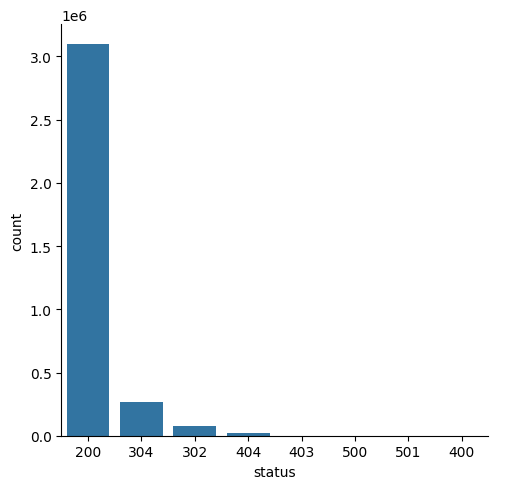

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.catplot(x='status', y='count', data=status_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

In [ ]:
log_freq_df = status_freq_df.withColumn('log(count)', F.log(status_freq_df['count']))
log_freq_df.show()

+------+-------+------------------+
|status|  count|        log(count)|
+------+-------+------------------+
|   200|3100524|14.947081687429097|
|   302|  73070|11.199173164785263|
|   304| 266773|12.494153388502301|
|   400|     15|  2.70805020110221|
|   403|    225|  5.41610040220442|
|   404|  20899| 9.947456589918252|
|   500|     65| 4.174387269895637|
|   501|     41| 3.713572066704308|
+------+-------+------------------+



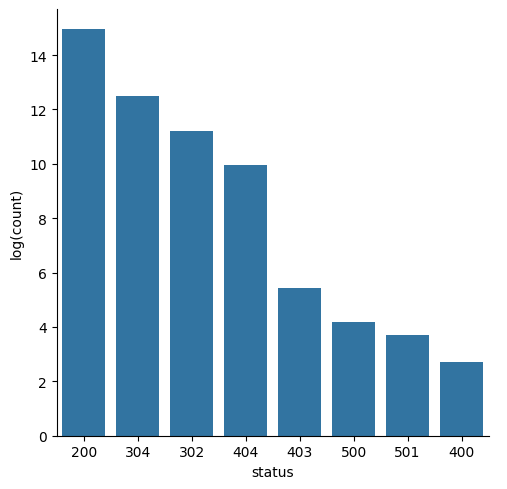

In [ ]:
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='status', y='log(count)', data=log_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

### Analyzing frequent hosts

In [ ]:
host_sum_df =(logs_df
               .groupBy('host')
               .count()
               .sort('count', ascending=False).limit(10))

host_sum_df.show(truncate=False)

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|21988|
|piweba4y.prodigy.com|16437|
|piweba1y.prodigy.com|12825|
|edams.ksc.nasa.gov  |11964|
|163.206.89.4        |9697 |
|news.ti.com         |8161 |
|www-d1.proxy.aol.com|8047 |
|alyssa.prodigy.com  |8037 |
|                    |7660 |
|siltb10.orl.mmc.com |7573 |
+--------------------+-----+



In [ ]:
host_sum_df = host_sum_df.toPandas()
host_sum_df.iloc[8]['host']

''

#### Dislay top 20 frequent endpoints

In [ ]:
paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))
paths_pd_df = paths_df.toPandas()
paths_pd_df

,endpoint,count
0,/images/NASA-logosmall.gif,208714
1,/images/KSC-logosmall.gif,164970
2,/images/MOSAIC-logosmall.gif,127908
3,/images/USA-logosmall.gif,127074
4,/images/WORLD-logosmall.gif,125925
5,/images/ksclogo-medium.gif,121572
6,/ksc.html,83909
7,/images/launch-logo.gif,76006
8,/history/apollo/images/apollo-logo1.gif,68896
9,/shuttle/countdown/,64736


#### Top 10 error endpoints

In [ ]:
not200_df = (logs_df
               .filter(logs_df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )

error_endpoints_freq_df.show(truncate=False)

+---------------------------------------+-----+
|endpoint                               |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |40082|
|/images/KSC-logosmall.gif              |23763|
|/images/MOSAIC-logosmall.gif           |15245|
|/images/USA-logosmall.gif              |15142|
|/images/WORLD-logosmall.gif            |14773|
|/images/ksclogo-medium.gif             |13559|
|/images/launch-logo.gif                |8806 |
|/history/apollo/images/apollo-logo1.gif|7489 |
|/                                      |6296 |
|/images/ksclogosmall.gif               |5669 |
+---------------------------------------+-----+



#### Total number of Unique Hosts

In [ ]:
unique_host_count = (logs_df.select('host').distinct().count())
unique_host_count

137934

#### Number of unique daily hosts

In [ ]:
host_day_df = logs_df.select(logs_df.host, 
                             F.dayofmonth('time').alias('day'))
host_day_df.show(5, truncate=False)

+--------------------+---+
|host                |day|
+--------------------+---+
|199.72.81.55        |1  |
|unicomp6.unicomp.net|1  |
|199.120.110.21      |1  |
|burger.letters.com  |1  |
|199.120.110.21      |1  |
+--------------------+---+
only showing top 5 rows



In [ ]:
host_day_distinct_df = (host_day_df
                          .dropDuplicates())
host_day_distinct_df.show(5, truncate=False)

+-----------------------+---+
|host                   |day|
+-----------------------+---+
|129.94.144.152         |1  |
|slip1.yab.com          |1  |
|205.184.190.47         |1  |
|204.120.34.71          |1  |
|ppp3_130.bekkoame.or.jp|1  |
+-----------------------+---+
only showing top 5 rows



#### Average number of daily requests per host

In [ ]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .select(col("day"), 
                                      col("count").alias("total_hosts")))

total_daily_reqests_df = (logs_df
                              .select(F.dayofmonth("time")
                                          .alias("day"))
                              .groupBy("day")
                              .count()
                              .select(col("day"), 
                                      col("count").alias("total_reqs")))

avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,1,98710,7610,12.971091
1,2,60265,4858,12.405311
2,3,130972,10238,12.792733
3,4,130009,9411,13.814579
4,5,126468,9640,13.119087
5,6,133380,10133,13.162933
6,7,144595,10048,14.390426
7,8,99024,7112,13.923510
8,9,95730,6699,14.290193
9,10,134108,8532,15.718237


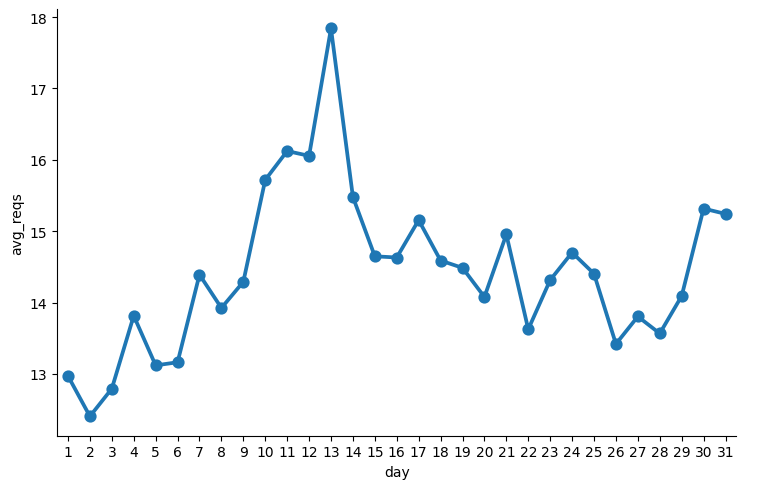

In [ ]:
c = sns.catplot(x='day', y='avg_reqs', 
                data=avg_daily_reqests_per_host_df, 
                kind='point', height=5, aspect=1.5)

In [ ]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.0 MB 3.1 MB/s eta 0:00:04
   ------ --------------------------------- 1.8/11.0 MB 3.6 MB/s eta 0:00:03
   -------- ------------------------------- 2.4/11.0 MB 3.4 MB/s eta 0:00:03
   ------------ --------------------------- 3.4/11.0 MB 3.7 MB/s eta 0:00:03
   --------------- ------------------------ 4.2/11.0 MB 3.7 MB/s eta 0:00:02
   ------------------ --------------------- 5.0/11.0 MB 3.7 MB/s eta 0:00:02
   -------------------- ------------------- 5.8/11.0 MB 3.7 MB/s eta 0:00:02
   ------------------------ --------------- 6.8/11.0 MB 3.8 MB/s eta 0:00:02
   ---------------------------- ----------- 7.9/11.0 MB 3.9 MB/s eta 0:00:01
   -----------------

### Machine learning segmentation model

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
from sklearn.metrics import silhouette_score
import numpy as np

class WebLogML:
    def __init__(self, logs_df):
        self.logs_df = logs_df
        self.feature_columns = None
        self.model = None
        self.scaler = None
        
    def extract_features(self):
        """Extract and prepare features for machine learning"""
        # Create behavioral features
        user_features = self.logs_df.groupBy('host').agg(
            # Volume metrics
            F.count('*').alias('total_requests'),
            F.countDistinct('endpoint').alias('unique_pages'),
            
            # Time-based features
            F.countDistinct(F.hour('time')).alias('active_hours'),
            F.countDistinct(F.dayofmonth('time')).alias('active_days'),
            
            # Performance metrics
            F.avg('content_size').alias('avg_content_size'),
            F.stddev('content_size').alias('std_content_size'),
            
            # Error metrics
            F.sum(F.when(F.col('status') >= 400, 1).otherwise(0)).alias('error_count'),
            
            # Session metrics
            F.avg(F.unix_timestamp('time')
                  .cast('double')).alias('avg_timestamp')
        )
        
        # Calculate derived features
        user_features = user_features.withColumn(
            'error_rate',
            F.col('error_count') / F.col('total_requests')
        ).withColumn(
            'requests_per_day',
            F.col('total_requests') / F.col('active_days')
        )
        
        self.feature_columns = [
            'total_requests',
            'unique_pages',
            'active_hours',
            'avg_content_size',
            'std_content_size',
            'error_rate',
            'requests_per_day'
        ]
        
        return user_features
    
    def prepare_ml_features(self, user_features):
        """Prepare features for machine learning"""
        # Assemble features into vector
        assembler = VectorAssembler(
            inputCols=self.feature_columns,
            outputCol='raw_features'
        )
        
        # Scale features
        scaler = StandardScaler(
            inputCol='raw_features',
            outputCol='scaled_features',
            withStd=True,
            withMean=True
        )
        
        # Dimensionality reduction with PCA
        pca = PCA(
            k=3,
            inputCol='scaled_features',
            outputCol='features'
        )
        
        # Transform data
        vectorized = assembler.transform(user_features)
        scaled = scaler.fit(vectorized).transform(vectorized)
        features = pca.fit(scaled).transform(scaled)
        
        return features
    
    def train_kmeans(self, features, k=4):
        """Train K-means clustering model"""
        kmeans = KMeans(
            k=k,
            seed=42,
            featuresCol='features',
            predictionCol='segment'
        )
        
        self.model = kmeans.fit(features)
        return self.model
    
    def evaluate_model(self, features):
        """Evaluate clustering model"""
        predictions = self.model.transform(features)
        
        # Calculate silhouette score
        evaluator = ClusteringEvaluator(
            predictionCol='segment',
            featuresCol='features',
            metricName='silhouette'
        )
        silhouette = evaluator.evaluate(predictions)
        
        # Calculate within-cluster sum of squares
        wssse = self.model.computeCost(features)
        
        # Calculate cluster sizes
        cluster_sizes = predictions.groupBy('segment').count().toPandas()
        
        return {
            'silhouette_score': silhouette,
            'wssse': wssse,
            'cluster_sizes': cluster_sizes
        }
    
    def analyze_clusters(self, features):
        """Analyze cluster characteristics"""
        predictions = self.model.transform(features)
        
        # Calculate cluster centers
        centers = pd.DataFrame(
            self.model.clusterCenters(),
            columns=self.feature_columns
        )
        
        # Calculate feature importance
        feature_importance = pd.DataFrame({
            'feature': self.feature_columns,
            'importance': np.abs(centers).mean(axis=0)
        }).sort_values('importance', ascending=False)
        
        # Analyze cluster separation
        cluster_separation = self.calculate_cluster_separation(centers)
        
        return {
            'centers': centers,
            'feature_importance': feature_importance,
            'cluster_separation': cluster_separation
        }
    
    def calculate_cluster_separation(self, centers):
        """Calculate separation between clusters"""
        n_clusters = len(centers)
        separation = np.zeros((n_clusters, n_clusters))
        
        for i in range(n_clusters):
            for j in range(n_clusters):
                separation[i,j] = np.linalg.norm(
                    centers.iloc[i] - centers.iloc[j]
                )
        
        return pd.DataFrame(
            separation,
            index=range(n_clusters),
            columns=range(n_clusters)
        )

def train_and_analyze_ml_model(logs_df):
    """Complete machine learning pipeline"""
    # Initialize ML pipeline
    ml_pipeline = WebLogML(logs_df)
    
    # Extract features
    print("Extracting features...")
    user_features = ml_pipeline.extract_features()
    
    # Prepare features for ML
    print("Preparing features for machine learning...")
    ml_features = ml_pipeline.prepare_ml_features(user_features)
    
    # Train model
    print("Training K-means model...")
    model = ml_pipeline.train_kmeans(ml_features)
    
    # Evaluate model
    print("Evaluating model...")
    evaluation = ml_pipeline.evaluate_model(ml_features)
    print(f"Silhouette Score: {evaluation['silhouette_score']:.3f}")
    print(f"WSSSE: {evaluation['wssse']:.3f}")
    
    # Analyze clusters
    print("Analyzing clusters...")
    analysis = ml_pipeline.analyze_clusters(ml_features)
    
    return {
        'model': model,
        'evaluation': evaluation,
        'analysis': analysis,
        'features': ml_features
    }

In [ ]:
# Alternative clustering algorithms
def train_alternative_models(features):
    models = {
        'kmeans': KMeans(k=4),
        'bisecting_kmeans': BisectingKMeans(k=4),
        'gaussian_mixture': GaussianMixture(k=4)
    }
    
    results = {}
    for name, model in models.items():
        model_fit = model.fit(features)
        results[name] = {
            'model': model_fit,
            'evaluation': evaluate_model(model_fit, features)
        }
    return results

In [ ]:
def detect_anomalies(features):
    # Isolation Forest for anomaly detection
    from sklearn.ensemble import IsolationForest
    
    iso_forest = IsolationForest(contamination=0.1)
    anomalies = iso_forest.fit_predict(features)
    return anomalies

In [ ]:
def predict_user_behavior(historical_data):
    # Time series prediction
    from prophet import Prophet
    
    model = Prophet()
    model.fit(historical_data)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    return forecast

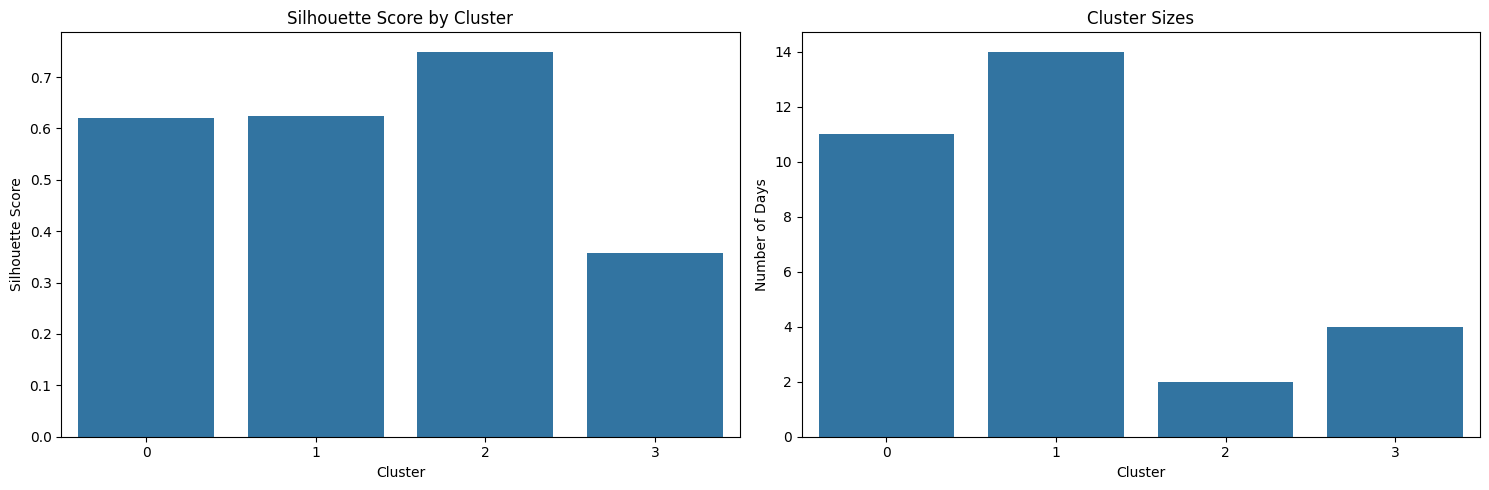

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd

def plot_model_performance(avg_daily_reqests_per_host_df):
    # Prepare data for clustering
    X = avg_daily_reqests_per_host_df[['avg_reqs', 'total_reqs', 'total_hosts']]
    
    # Perform k-means clustering
    n_clusters = 4  # You can adjust this number
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_values = silhouette_samples(X, cluster_labels)
    
    # Create evaluation data
    cluster_silhouettes = pd.DataFrame({
        'segment': range(n_clusters),
        'silhouette': [np.mean(silhouette_values[cluster_labels == i]) 
                      for i in range(n_clusters)]
    })
    
    cluster_sizes = pd.DataFrame({
        'segment': range(n_clusters),
        'count': [np.sum(cluster_labels == i) for i in range(n_clusters)]
    })
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Silhouette score by cluster
    sns.barplot(x='segment', y='silhouette', 
               data=cluster_silhouettes, ax=ax1)
    ax1.set_title('Silhouette Score by Cluster')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Silhouette Score')
    
    # Cluster sizes
    sns.barplot(x='segment', y='count', 
               data=cluster_sizes, ax=ax2)
    ax2.set_title('Cluster Sizes')
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Number of Days')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'cluster_silhouettes': cluster_silhouettes,
        'cluster_sizes': cluster_sizes,
        'overall_silhouette': silhouette_avg
    }

# Call the function
results = plot_model_performance(avg_daily_reqests_per_host_df)

In [ ]:
def generate_summary_stats(kmeans, X, cluster_labels, silhouette_avg):
    # Calculate WSSSE
    wssse = kmeans.inertia_
    
    # Get cluster sizes
    unique, counts = np.unique(cluster_labels, return_counts=True)
    
    stats = {
        'total_segments': len(unique),
        'largest_segment': counts.max(),
        'silhouette_score': silhouette_avg,
        'wssse': wssse
    }
    
    # Print summary
    print("\n=== Model Performance Summary ===")
    print(f"Number of Segments: {stats['total_segments']}")
    print(f"Largest Segment Size: {stats['largest_segment']}")
    print(f"Overall Silhouette Score: {stats['silhouette_score']:.3f}")
    print(f"Within-Cluster Sum of Squares: {stats['wssse']:.3f}")
    
    return stats

# First perform clustering
def perform_clustering(df):
    # Prepare data for clustering
    X = df[['avg_reqs', 'total_reqs', 'total_hosts']]
    
    # Perform k-means clustering
    n_clusters = 4  # You can adjust this number
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    return kmeans, X, cluster_labels, silhouette_avg

# Run the analysis
kmeans, X, cluster_labels, silhouette_avg = perform_clustering(avg_daily_reqests_per_host_df)
stats = generate_summary_stats(kmeans, X, cluster_labels, silhouette_avg)


=== Model Performance Summary ===
Number of Segments: 4
Largest Segment Size: 14
Overall Silhouette Score: 0.597
Within-Cluster Sum of Squares: 1761939757.943



Segment 0 Profile:
Type: Regular Days
Size: 11 days
Characteristics:
- Average Requests per Host: 14.41
- Total Requests: 127003.73
- Unique Hosts: 8864.18

Segment 1 Profile:
Type: Regular Days
Size: 14 days
Characteristics:
- Average Requests per Host: 14.17
- Total Requests: 95386.14
- Unique Hosts: 6748.50

Segment 2 Profile:
Type: Regular Days
Size: 2 days
Characteristics:
- Average Requests per Host: 13.25
- Total Requests: 64126.50
- Unique Hosts: 4841.50

Segment 3 Profile:
Type: Regular Days
Size: 4 days
Characteristics:
- Average Requests per Host: 15.96
- Total Requests: 150228.00
- Unique Hosts: 9425.75


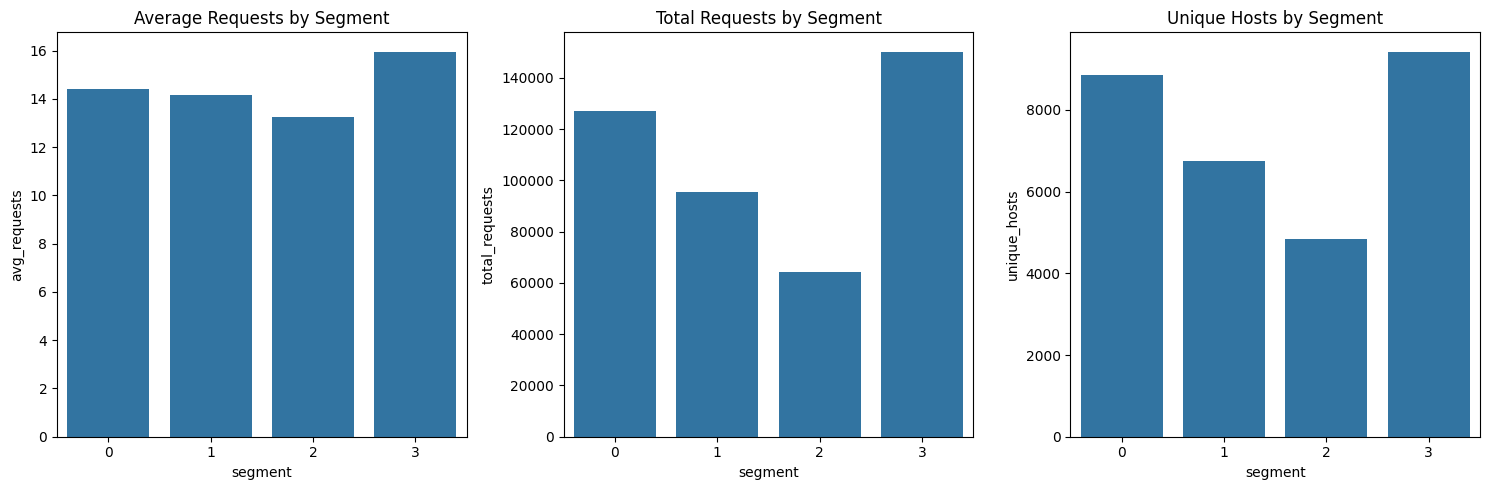

In [ ]:
def generate_segment_profiles(kmeans, X, cluster_labels):
    # Get cluster centers and convert to DataFrame
    centers = pd.DataFrame(
        kmeans.cluster_centers_,
        columns=['avg_reqs', 'total_reqs', 'total_hosts']
    )
    
    # Get cluster sizes
    sizes = pd.Series(cluster_labels).value_counts().sort_index()
    
    profiles = []
    
    for segment in range(len(centers)):
        center = centers.iloc[segment]
        size = sizes[segment]
        
        profile = {
            'segment': segment,
            'size': size,
            'characteristics': {
                'avg_requests': center['avg_reqs'],
                'total_requests': center['total_reqs'],
                'unique_hosts': center['total_hosts']
            }
        }
        
        # Determine segment type based on characteristics
        if center['avg_reqs'] > centers['avg_reqs'].mean() * 1.5:
            profile['type'] = 'High Traffic Days'
        elif center['total_hosts'] > centers['total_hosts'].mean() * 1.5:
            profile['type'] = 'High User Days'
        elif center['total_reqs'] > centers['total_reqs'].mean() * 1.5:
            profile['type'] = 'Peak Activity Days'
        else:
            profile['type'] = 'Regular Days'
        
        profiles.append(profile)
        
        # Print profile summary
        print(f"\nSegment {segment} Profile:")
        print(f"Type: {profile['type']}")
        print(f"Size: {profile['size']} days")
        print("Characteristics:")
        print(f"- Average Requests per Host: {profile['characteristics']['avg_requests']:.2f}")
        print(f"- Total Requests: {profile['characteristics']['total_requests']:.2f}")
        print(f"- Unique Hosts: {profile['characteristics']['unique_hosts']:.2f}")
    
    return profiles

# Use previous clustering results to generate profiles
profiles = generate_segment_profiles(kmeans, X, cluster_labels)

# Optional: Create visualization of segment characteristics
def visualize_segment_profiles(profiles):
    # Convert profiles to DataFrame for easier plotting
    prof_df = pd.DataFrame([
        {
            'segment': p['segment'],
            'type': p['type'],
            'size': p['size'],
            'avg_requests': p['characteristics']['avg_requests'],
            'total_requests': p['characteristics']['total_requests'],
            'unique_hosts': p['characteristics']['unique_hosts']
        }
        for p in profiles
    ])
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot key metrics by segment
    sns.barplot(data=prof_df, x='segment', y='avg_requests', ax=axes[0])
    axes[0].set_title('Average Requests by Segment')
    
    sns.barplot(data=prof_df, x='segment', y='total_requests', ax=axes[1])
    axes[1].set_title('Total Requests by Segment')
    
    sns.barplot(data=prof_df, x='segment', y='unique_hosts', ax=axes[2])
    axes[2].set_title('Unique Hosts by Segment')
    
    plt.tight_layout()
    plt.show()
    
    return prof_df

# Create visualization
segment_df = visualize_segment_profiles(profiles)